In [1]:
import glob 
import pandas as pd 
import numpy as np
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
import os 
data_dir = os.getenv("DATADIR")
data_dir = data_dir + "0_SUMS_Catalogs/CompleteCatalog/"


# First compile catalog of all masked sources 
# Get gaia / simbad crossmatch in topcat 
# Remove duplicates 
run = False
if run:
    for galaxy in ['lmc','smc']:
        # FILE HANDLING
        files = glob.glob(f"H:/Data/SUMS_Tractor_Data/{galaxy}/*X/*/*masked*")

        # Combine all files 
        df = pd.concat([pd.read_csv(f) for f in files])
        init_size = df.shape[0]

        # Sort by RA
        df = df.sort_values('ra')
        df = df.reset_index(drop=True)

        # Find duplicate sources if ra/dec is equivalent, will do additional step in topcat 
        df = df.drop_duplicates(subset=['ra','dec']).reset_index(drop=True)

        df.to_csv(data_dir + f'MaskedSources/{galaxy}_masked_sources.csv',index=False)

In [3]:
# Doesn't seem like there are dupes in topcat 
df = pd.read_csv(data_dir + 'MaskedSources/topcat_masked_sources.csv').reset_index(drop=True)

# Lets do matches within some radius 
radius = 0.5 # arcsec
df = df[df.angDist<radius].reset_index(drop=True)

# If multiple things got assigned the same simbad source, take the closest 
rows = []
for ind, row in df.iterrows():
    group = df[df.main_id == row.main_id]
    if len(group) > 1:
        best = group[group.angDist == group.angDist.min()]
    else:
        best = group
    rows.append(best)

df = pd.concat(rows).reset_index(drop=True)
# Sp Type 
sum_sptype = 0 
for typesp in ['O','B','A','F','G','K','M','W','L','s']:
    print(f'{typesp} type: ', df.sp_type.str.startswith(typesp).sum())
    sum_sptype += df.sp_type.str.startswith(typesp).sum()
print('Total: ', df.shape[0])
print('Classified: ', sum_sptype)
sum_nan = df.sp_type.isna().sum()
print('NaN: ', sum_nan)
print('Remaining: ',df.shape[0] - sum_sptype - sum_nan)
print(df.shape)

O type:  329
B type:  438
A type:  34
F type:  50
G type:  19
K type:  10
M type:  3
W type:  33
L type:  1
s type:  2
Total:  1220
Classified:  919
NaN:  301
Remaining:  0
(1220, 47)


In [4]:
# What fraction have an OB star within 0.5"
print((329+438) / 1220)

# What fraction crossmatched to simbad is classified as an OB star (0.5")
print((329+438) / 919) # Classified vs total

0.6286885245901639
0.8346028291621328


In [5]:
# What fraction have an OB or WR star within 1"
print((453+570+43) / 1606)

# What fraction crossmatched to simbad is classified as an OB or WR star (1")
print((453+570 + 43) /1200) # Classified vs total

0.663760896637609
0.8883333333333333


In [39]:
df.main_type.value_counts()

main_type
Star                   855
BlueSG                 173
EclBin                 157
EmLine*                122
Be*_Candidate           59
WolfRayet*              48
SB*                     23
post-AGB*_Candidate     21
Supergiant              18
EllipVar                16
**                      16
Variable*               15
HighPM*                  9
LongPeriodV*             8
RedSG                    8
HighMassXBin             7
RGB*_Candidate           6
PulsV*                   6
BlueSG_Candidate         6
ChemPec*                 5
YSO                      3
NearIR                   3
Cluster*                 3
Be*                      3
HIIReg                   2
HotSubdwarf              2
YellowSG                 2
Cepheid                  1
Infrared                 1
X                        1
Association              1
EmObj                    1
MolCld                   1
post-AGB*                1
RotV*                    1
YSO_Candidate            1
RedSG_Candidate   

(1606, 47)
cat
MCPS    1336
USNO     270
Name: count, dtype: int64


(6.0, 21.0)

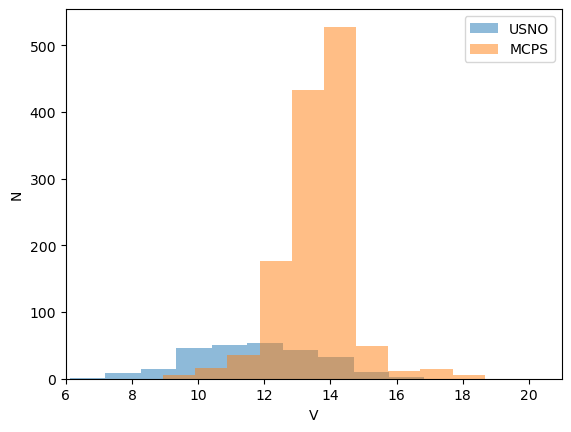

In [6]:
# The ones in USNO tend to be brighter, makes sense
import matplotlib.pyplot as plt
df = pd.read_csv(data_dir + 'MaskedSources/topcat_masked_sources.csv').reset_index(drop=True)
print(df.shape)
# How many are usno? 
print(df.cat.value_counts())
plt.hist(df.loc[df.cat=='USNO','V'],alpha=0.5,label='USNO')
plt.hist(df.loc[df.cat=='MCPS','V'],alpha=0.5,label='MCPS')
plt.legend()
plt.xlabel('V')
plt.ylabel('N')
plt.xlim(6,21)